In [1]:
import torch
from torch_geometric.data import Data
import numpy as np
import networkx as nx
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import matplotlib.pyplot as plt
import scipy.special as SS
import scipy.stats as SSA

In [21]:
WN = np.loadtxt('W_avg.csv')
pop = np.loadtxt('pop_new.csv')

In [87]:
size = 1000000
r = 0.025
p = r/(r+2.5)
cut_off = 200
initials = []

while len(initials) < size:
    sample = np.random.negative_binomial(r, p)
    if sample <= cut_off:
        initials.append(sample)

initials = np.array(initials)
print(np.mean(initials))

2.158564


In [86]:
size = 1000000
r = 0.025
p = r/(r+2.5)
cut_off = 200

initials = []

for _ in range(size):
    sample = np.random.negative_binomial(r, p)
    
    while sample > cut_off:
        # Here, we're drawing from a truncated lower end of the distribution
        # By reducing r value, we're skewing our resamples to be lower, 
        # but since it's only for values that initially exceed the cut-off, 
        # this might balance things out more.
        sample = np.random.poisson(2.5)
        
    initials.append(sample)

initials = np.array(initials)
print(np.mean(initials))

2.151637


In [73]:
np.mean(initials)

1.555371

(array([0.12959459, 0.00189189, 0.00121622, 0.00054054, 0.00040541,
        0.00054054, 0.00013514, 0.00027027, 0.00040541, 0.00013514]),
 array([ 0. ,  7.4, 14.8, 22.2, 29.6, 37. , 44.4, 51.8, 59.2, 66.6, 74. ]),
 <BarContainer object of 10 artists>)

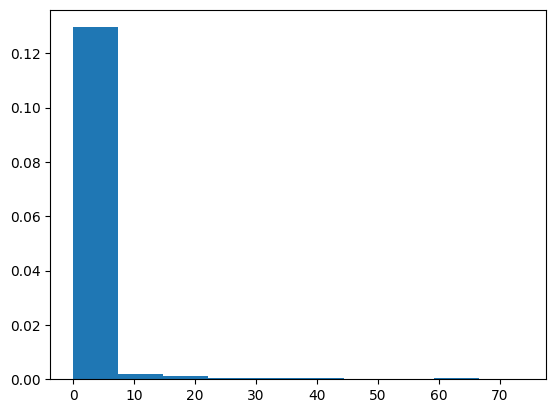

In [51]:
plt.hist(initials, density=True)

In [ ]:
# create a graph
A = np.array([[0.25 , 0.25, 0.4, 0.1 ],
        [0.25, 0.75 , 0. , 0. ],
        [0.4, 0. , 0.55 , 0.05],
        [0.1 , 0 , 0.05, 0.85 ]])
# adjacency_matrix = torch.tensor(WN)
adjacency_matrix = torch.tensor(A)
# Get the indices where the adjacency matrix has a non-zero value
edge_index = torch.nonzero(adjacency_matrix, as_tuple=False).t()

# If your adjacency matrix has edge weights, you can get them like this:
edge_weight = adjacency_matrix[edge_index[0], edge_index[1]]

In [ ]:
def mixed_distribution_torch(lam, n, p_prime):
    # Derive p from n and lam for negative binomial
#     p = n / (n + lam)
#     p_prime = 1-p
    # Decide which distribution to sample from
    distribution_choice = torch.multinomial(torch.tensor([0.8, 0.2]), 1).item()

    if distribution_choice == 0:  # Poisson
        return torch.poisson(lam).item()
    else:  # Negative binomial
        return torch.distributions.negative_binomial.NegativeBinomial(total_count=n, probs=p_prime).sample().item()

In [131]:
class EpidemicSimulator(MessagePassing):
    def __init__(self, r, p, weight, max_time_step):
        super(EpidemicSimulator, self).__init__(aggr='add')
        self.r = r
#         self.p = p
        self.p_prime = 1-p
        self.max_time_step = max_time_step
        self.Z = 3 # latent period
        self.Zb = 1 # scale parameter for Z
        self.D = 5 # infectious period
        self.Db = 1 # scale parameter for beta
        self.weight = torch.Tensor(weight)
        self.offspring = []
    
    def forward(self, x, edge_index, edge_attr, step):
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x, edge_attr=edge_attr, step=step)

    def message(self, x_j, edge_index, edge_attr, step):
        # x_j has shape [E, num_features]
        # edge_attr has shape [E, num_edge_features]
        # Get the new infections from x_j.
#         new_infections = x_j[:, 0:1]  # Shape: [E, 1]
        new_infectors = x_j[:, 2+step:3+step] ## the infectors at time ti
        temp = new_infectors.round().int()
        cases = temp.squeeze().tolist()
        # Initialize an empty tensor to store the results
        results = torch.zeros_like(new_infectors)
        # Generate negative binomial for each size
        for i, size in enumerate(cases):
#             print(size)
            if size>0:
                offspring_per_case = torch.distributions.negative_binomial.NegativeBinomial(self.r,self.p_prime).sample(sample_shape=torch.Size([size]))
            #torch.distributions.Categorical(self.weight).sample(sample_shape=torch.Size([size]))
                self.offspring.extend(offspring_per_case.tolist())
#                 offspring_per_case = torch.zeros(size)
#                 for j in torch.arange(size):
#                     offspring_j = torch.distributions.Categorical(self.weight).sample((1,))
#                     offspring_per_case[j] = offspring_j*1.62
#                     print(offspring_j)
#                     self.offspring.append(offspring_j.item()*1.62)
            #torch.distributions.negative_binomial.NegativeBinomial(self.r,self.p_prime).sample(sample_shape=torch.Size([size]))
            # torch.Tensor(np.array([2]*size))
#            
# mixed_distribution_torch(torch.tensor(2.5), self.r, self.p_prime)
                temp_sum = offspring_per_case.sum()
            else:
                temp_sum = 0
#             print(temp_sum)
            results[i] = temp_sum
        ######^^^^^^#######
        # Compute the messages.
#         messages = new_infections * edge_attr.view(-1, 1)
        messages = results * edge_attr.view(-1, 1)
        return messages

    def update(self, aggr_out, x, step):
        # x has shape [N, num_features], it is the original node features
        # The new infections are the aggregated messages.
        new_infections = aggr_out # aggr_out has shape [N, 1], it contains the updated infections
        #### Add the effective infections to the column corresponding to the current step.####
        ## immu first
        population = x[:, 1:2]
        total_infection = torch.sum(x[:, 2:3+step], dim=1,keepdim=True) 
        rate = (population - total_infection) / population # Compute the rate.
        rate[rate<0] = 0
        
        new_effective_infections = new_infections*rate
        new_infections_int  = new_effective_infections.round().int()
        ### diffuse the new_infections to different times 
        inf_sizes = new_infections_int.squeeze().tolist()
        for i, inf_size_i in enumerate(inf_sizes):
            gamma_dist1 = torch.distributions.Gamma(self.Z, 1/self.Zb)
            gamma_dist2 = torch.distributions.Gamma(self.D, 1/self.Db)
            latency_p = gamma_dist1.rsample(sample_shape=torch.Size([inf_size_i]))
            infectious_p = gamma_dist2.rsample(sample_shape=torch.Size([inf_size_i]))
            v = torch.rand(inf_size_i)
            delay_days = latency_p + v * infectious_p
#             print(step, delay_days)
            for j,delay_t in enumerate(delay_days):
                t_j = (3+step+delay_t).ceil().int()
                if t_j > self.max_time_step:
                    pass
                else:
                    x[i,t_j] = x[i,t_j] + 1
        ######^^^^^^#######
        # The rest of the features remain the same.
        other_features = x[:, 2:].clone()
        # Concatenate the new infections, the population, and the other features to get the new node features.
        x_new = torch.cat([new_infections.clone(), population, other_features], dim=1)
        return x_new, self.offspring

def simulate_dynamics(data, R0, r, num_steps,edge_index):
    p = r/(R0+r)  
    
#     x_cutoff = 150
#     weights = np.zeros(x_cutoff)
#     for i in range(x_cutoff):
#         temp1=SS.gamma(r+i)/(SS.gamma(r)*SS.gamma((i+1)))*np.power(p,r)*np.power((1-p),i)
#         weights[i] = temp1
#     weights_n = weights/np.sum(weights)
    xx = np.arange(0,100,1)  # define the range of x values the cutoff is 200
    pmf = SSA.nbinom.pmf(xx, r, p)  # calculate the probability mass function
    weights_n = pmf/np.sum(pmf)
#     cpp_results = np.loadtxt('ss_100_n.txt') ## 300
#     cpp_results_n = cpp_results/np.sum(cpp_results)
    simulator = EpidemicSimulator(r,p, weights_n, max_time_step=61)
    x = data.x
    for ti in range(num_steps):
        x,newcases = simulator(x, edge_index, data.edge_attr, ti)
    return x, newcases

In [95]:
cpp_results = np.loadtxt('ss_100_n.txt') ## 300
cpp_results_n = cpp_results/np.sum(cpp_results)
temp = torch.distributions.Categorical(torch.Tensor(cpp_results_n)).sample((100,))

In [ ]:
torch.tensor([10]).item()*1.62

In [ ]:
%run ../codes/branching_gnn.py

## test R0=2.5

In [ ]:
rs = np.array([20.0, 10.0, 5.0, 2.0, 1.0, 0.5, 0.2, 0.1, 0.05, 0.025]) 

In [ ]:
pop = np.array([1000]*4)## populations

In [89]:
num_fips = len(pop)
T = 60
l0 = 1859-1 # start with New York County NY in python -1, in matlab is 1859
E_mean_county = np.zeros((9,60))
E_std_county = np.zeros((9,60))
En_NewInf = np.zeros((300,num_fips,T))

In [132]:
for e_i in range(1):
    print(e_i)
    xx = np.zeros((num_fips,62)) # number of nodes, the columns of attributes
    xx[:,1] = pop ## populations
    ## col_2 is the new infections generated by the new infectors
    xx[l0,2] = 100 ## the new infections at time 0 
    # xx[0,2] = 10
    # xx[2,0] = 100 ## the new infections initials
    xx = torch.tensor(xx,dtype=torch.float)

    adjacency_matrix = torch.tensor(WN)
    # Get the indices where the adjacency matrix has a non-zero value
    edge_index = torch.nonzero(adjacency_matrix, as_tuple=False).t()
    # If your adjacency matrix has edge weights, you can get them like this:
    edge_weight = adjacency_matrix[edge_index[0], edge_index[1]]

    data = Data(x=xx, edge_index=edge_index, edge_attr=edge_weight)
    NewInf_i, newcases = simulate_dynamics(data, R0=2.5, r=0.025, num_steps=T, edge_index=edge_index)
    En_NewInf[e_i,:,:] = NewInf_i[:,2:]

0


In [153]:
np.sum(np.array(newcases)>1000)

4

In [134]:
np.mean(newcases)

2.499701747514464

In [152]:
newcases

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 15.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4.0,
 211.0,
 0.0,
 0.0,
 10.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 157.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 6.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 30.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 23.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 128.0,
 0.0,
 1.0,
 12.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,

In [143]:
cc = np.array(En_NewInf[:1,:,:])
# cc1 = np.array(test1)[:,2:]

In [144]:
cc.shape

(1, 3142, 60)

In [145]:
ccc = cc/pop[None,:,None]*100000
# ccc1 = cc1/pop[:,None]*100000

In [146]:
dd  = np.sum(ccc[:,:,:60]>10,axis=1)
# dd1  = np.sum(ccc1[:,:60]>10,axis=0)

In [147]:
dd.shape

(1, 60)

In [148]:
ddd = np.mean(dd,axis=0)

In [128]:
NewInf_ode = np.loadtxt('metapop_R025.csv')
infec_perpop = NewInf_ode/pop[:,None]*100000
county_ode = np.sum(infec_perpop>10,axis=0)

In [149]:
dd[:,-1]

array([46])

Text(0, 0.5, 'counties with daily infections per 100000>10')

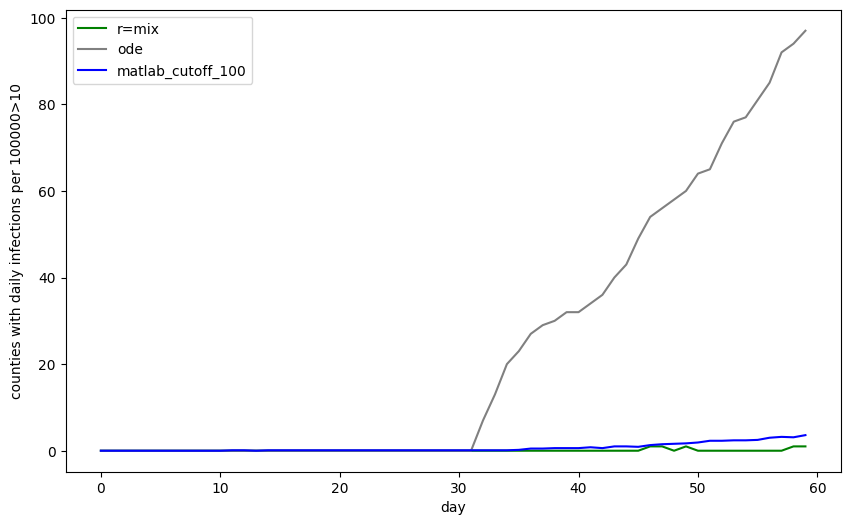

In [130]:
plt.figure(figsize=(10,6))
plt.plot(ddd,label='r=mix',color='green')
# plt.plot(dd1,label='r=0.025',color='green')
plt.plot(county_ode,label='ode',color='gray')
# plt.plot(county_mat_avg ,label='matlab_cutoff_300',color='red')
plt.plot(county_mat_avg_100 ,label='matlab_cutoff_100',color='blue')
plt.legend()
plt.xlabel('day')
plt.ylabel('counties with daily infections per 100000>10')

In [ ]:
para_dict = np.load('para_dict.npy',allow_pickle=True)
    ## set parameters
para_dict[90]

In [ ]:
torch.Tensor([0.5]).round()

In [112]:
import scipy.io

# Load the .mat file
mat_data = scipy.io.loadmat('/Users/qingyao/OneDrive - cumc.columbia.edu/branchingmodel/SpatialSpread_simulation/NewInf_0025.mat')

In [113]:
mat_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'NewInf'])

In [114]:
mat_newinf_100 = mat_data['NewInf']

In [115]:
mat_infec_perpop_100 = mat_newinf_100/pop[:,None,None]*100000

In [116]:
county_mat_100 = np.sum(mat_infec_perpop_100>10,axis=0)

In [117]:
county_mat_avg_100 = np.mean(county_mat_100,axis=1)